# House prices analysis for Kaggle competition

by
Greg Pelletier

The Kaggle House Price Competition is a challenge that encourages the application of advanced regression techniques and creative feature engineering to build models that can accurately predict house prices. Participants explore the data, create and engineer features, build models, and submit predictions. The competition is an excellent starting point for practical experience in data science and machine learning. The following link is the official Web page for the kaggle house price competition:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In this notebook I analyze the kaggle house price data using a Stacking Regression method available at this link to the stepAIC module:

https://github.com/gjpelletier/stepAIC

### Stacking Regression

The **stacking** function in the stepAIC module provides output of a fitted regression model and summary statistics using the sklearn StackingRegressor function for ensemble modeling with any combination of sklearn base regressors which can be turned 'on' or 'off' with the following optional keyword arguments:

- Lasso= 'on' (default) or 'off'        uses LassoCV
- Ridge= 'on' (default) or 'off'        uses RidgeCV
- ElasticNet= 'on' (default) or 'off'   uses ElasticNetCV
- SGD= 'on' (default) or 'off'          uses SGDRegressor
- KNN= 'on' (default) or 'off'          uses KNeighborsRegressor
- SVR= 'on' (default) or 'off'          uses SVR(kernel='rbf')
- MLP= 'on' or 'off' (default)          uses MLPRegressor
- XGB= 'on' (default) or 'off'          uses GradientBoostingRegressor
- DecisionTree= 'on' (default) or 'off' uses DecisionTreeRegressor
- RandomForest= 'on' (default) or 'off' uses RandomForestRegressor

Stacking regression is an **ensemble** machine learning technique that improves predictive accuracy by combining multiple base regression models. Instead of selecting a single best model, stacking leverages multiple models to generate a more robust final prediction.

**How Stacking Regression Works:**
- **Base Regressors (Level 0 Models):**  
    - Several regression models (e.g., Lasso, Ridge, Elastic, DecisionTree, RandomForest, etc.) are trained independently on the dataset.
    - Each model learns different aspects of the data.

- **Meta-Model (Level 1 Model):**  
    - A separate model (linear regression) is trained to **learn from the outputs of base models**.
    - It assigns strength weights to each base model’s predictions, determining which models contribute the most to final accuracy.

- **Final Prediction:**  
    -The meta-model makes a final prediction based on the base models' combined outputs.

#### Kaggle competition leaderboard score using this notebook

The analysis documented in this notebook resulted in a leaderboard score of 0.12489. Any score between 0.1 to 0.15 is considered to be a "good" score.

## Install the stacking function from stepAIC

In [1]:
# # Run the following commands to install stepAIC for the first time
# !pip install git+https://github.com/gjpelletier/stepAIC.git

# # Run the following commands to upgrade stepAIC to the latest versions
# !pip install git+https://github.com/gjpelletier/stepAIC.git --upgrade

## Import libraries and functions

In [2]:
from stepAIC import stacking
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, gamma, lognorm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Read raw train and test data downloaded from kaggle

The csv files used in this notebook for the training data (train.csv) and testing data (test.csv) are available to download from kaggle at the following link:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [3]:
# read train data into dataframe df_train
train_path = "/mnt/c/z/kaggle/house_prices/data/train.csv"
df_train = pd.read_csv(train_path)
print("Full train dataset shape is {}".format(df_train.shape))
# print(df_train.head())

# read test data into dataframe df_test
test_path = "/mnt/c/z/kaggle/house_prices/data/test.csv"
df_test = pd.read_csv(test_path)
print("Full test dataset shape is {}".format(df_test.shape))
# print(df_test.head())

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


## Numerical and categorical features

The training data include the following numeric (quantitative) and categorical (qualitative) features:

In [4]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
print('Numeric features (quantitative): \n', quantitative)
print('Categorical features (qualitative): \n', qualitative)

Numeric features (quantitative): 
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features (qualitative): 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functiona

## Remove high leverage training data

It is well known that there are some high-leverage data points in the training data that we should remove from the analysis. We will start by plotting the SalePrice vs above ground living area (GrLivArea) to look for data points in the training data that have high leverage

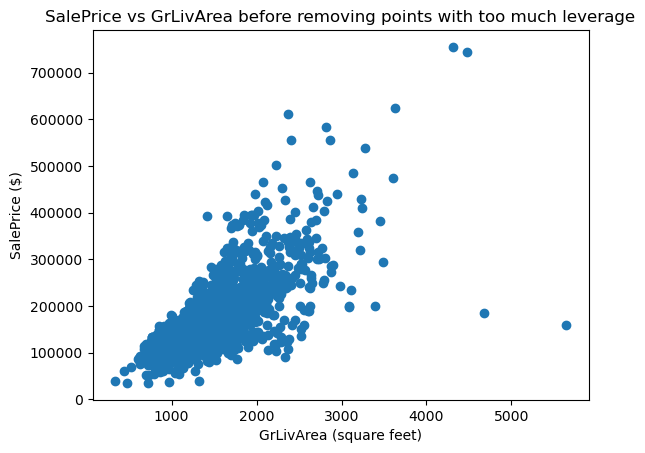

In [5]:
#GrLivArea vs. SalePrice
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.xlabel('GrLivArea (square feet)')
plt.ylabel('SalePrice ($)')
# plt.xscale("log")
# plt.yscale("log")
plt.title('SalePrice vs GrLivArea before removing points with too much leverage');

Data points with GrLivArea > 4500 square feet appear to be outliers that exert too much leverage. We will remove these data ponts from the training analysis

In [7]:
# # outliers listed by https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1 (how??)
# outliers = [30, 88, 462, 631, 1322]
# df_train = df_train.drop(df_train.index[outliers])

# # remove the high leverage outlier points
df_train = df_train[df_train['GrLivArea'] < 4500]
print("Train dataset with leverage points removed shape is {}".format(df_train.shape))

Train dataset with leverage points removed shape is (1458, 81)


## Combine the train and test data for transformations and pre-processing steps

In [9]:
#Combine Datasets
data = pd.DataFrame()
data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))
print("Combined train and test dataset shape is {}".format(data.shape))
# print(data.head())

Combined train and test dataset shape is (2917, 79)


## Correlations and clusters of numeric features

Next we will take a brief detour to show the correlations between the numeric features and a hierarchically-clustered heatmap. We don't use this for the following analysis, but it may be useful for considering possible future improvements to the feature engineering.

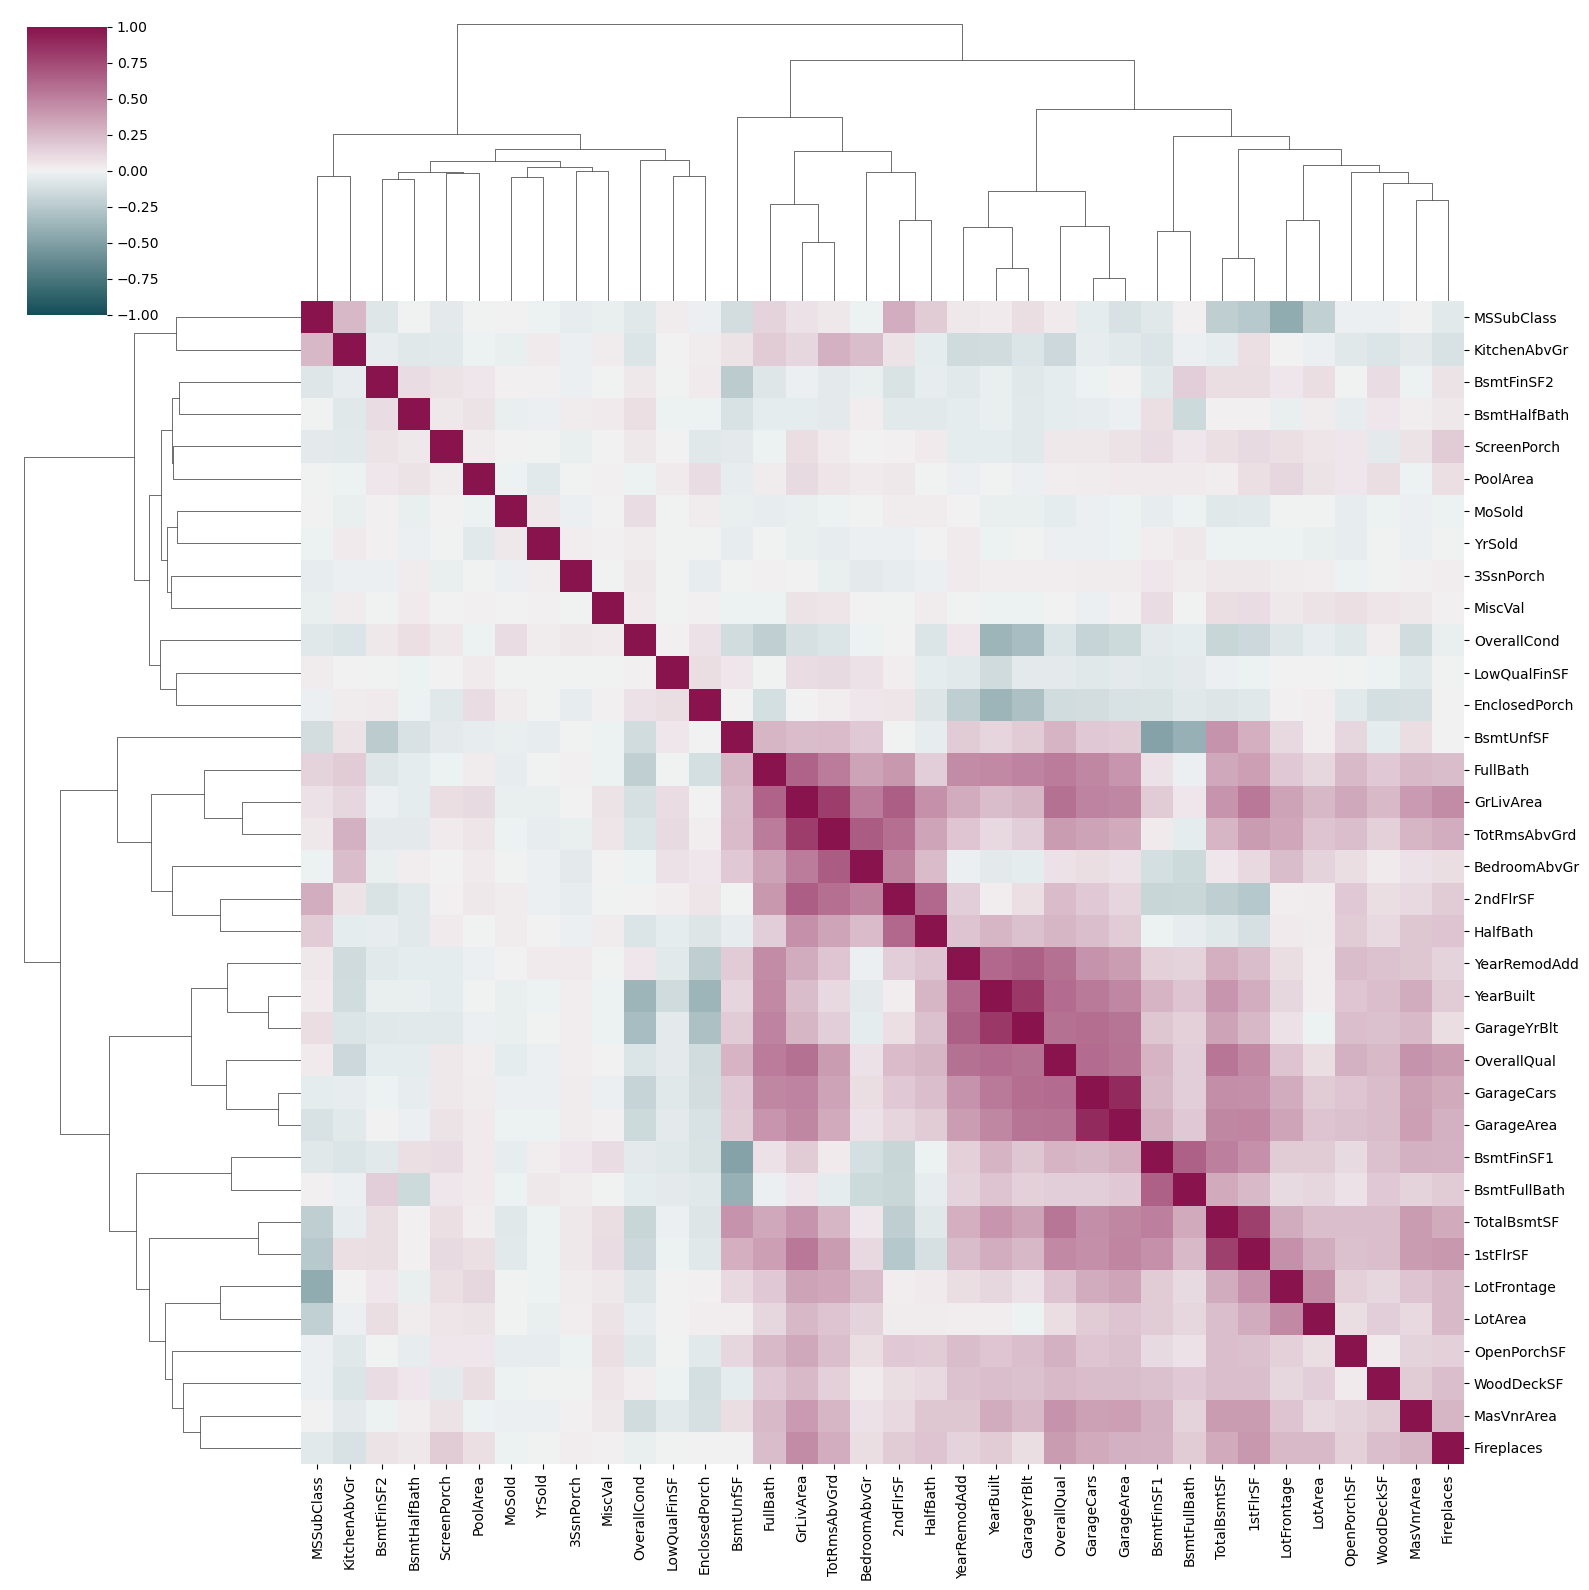

In [10]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        method="complete",
        annot=annot,
        figsize=figsize,
        **kwargs,
    )

# extract the numeric features from data
# df = data.select_dtypes(include=['number'])
df = data[quantitative]
# cosine transform cyclical numeric feature 'MoSold' for correlation analysis
df['MoSold'] = (-np.cos(0.5236 * df['MoSold']))   # 2*np.pi/12 = 0.5236
# cmap="icefire"
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
figsize=(16,16)
corrplot(df, annot=None, cmap=cmap)

## Missing data

From >40% to 100% of the data are missing for six features 

(0.0, 100.0)

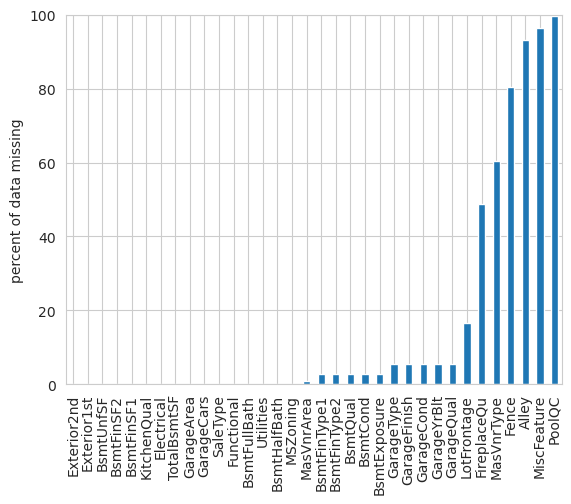

In [11]:
sns.set_style("whitegrid")
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing = 100 * missing / data.shape[0]
missing.plot.bar()
plt.ylabel("percent of data missing");
plt.ylim(0, 100) # Set y-limits;

## Encoding of categorical (qualitative) features

In [12]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(df_train, q)
    # encode(data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)
# print(df_train[qual_encoded])

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [13]:
'''
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
'''

"\ndef spearman(frame, features):\n    spr = pd.DataFrame()\n    spr['feature'] = features\n    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]\n    spr = spr.sort_values('spearman')\n    plt.figure(figsize=(6, 0.25*len(features)))\n    sns.barplot(data=spr, y='feature', x='spearman', orient='h')\n"

## Clustering

Exploratory analysis, may or may not be useful for future versions of the analysis

0.7567053019838227


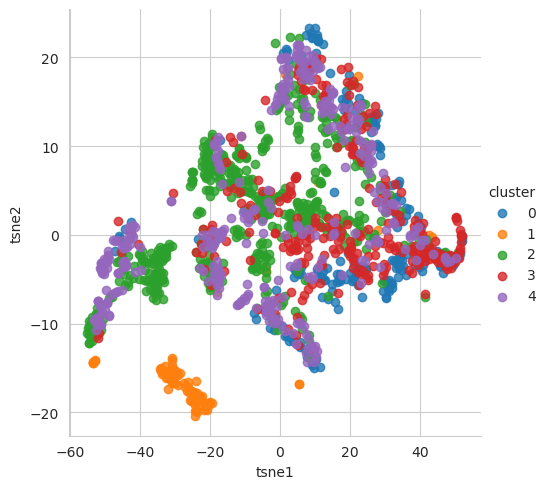

In [14]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df_train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

## Data cleaning

The following sections on data cleaning, feature transformations and engineering, encoding of categerical features, and standardizing numeric features are adapted from the Jupyter notebook published at the following githup repo:

https://github.com/MerleSt/HousingPricePrediction

In [15]:
data2 = data.copy()

In [16]:
# ensure proper data type
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

In [17]:
# Categorical missing data

# Impute using constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna('None')


# Impute using column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [18]:
# Get categorical columns with at least one missing value
data2.select_dtypes('object').loc[:, data2.isna().sum()>0].columns

Index([], dtype='object')

In [19]:
data3 = data2.copy()

## Numeric features

In [20]:
# Numeric features

def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
    ]:
    data3 = knn_impute(data3, column)    

In [21]:
data4=data3.copy()

## Feature engineering

In [22]:
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] +
                                                       data4["FullBath"] +
                                                       data4["HalfBath"] +
                                                       data4["KitchenAbvGr"])

data4['Total_Home_Quality'] = data4['OverallQual'] + data4['OverallCond']

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))

data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]

In [23]:
data5 = data4.copy()

## Feature transformations

In [24]:
# Log transform skewed features
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,0.992721,0.992721,True
1,LotArea,13.109495,13.109495,True
2,OverallQual,0.189591,0.189591,False
3,OverallCond,0.569314,0.569314,True
4,YearBuilt,-0.599194,0.599194,True
5,YearRemodAdd,-0.450134,0.450134,False
6,MasVnrArea,2.611709,2.611709,True
7,BsmtFinSF1,0.980813,0.980813,True
8,BsmtFinSF2,4.144471,4.144471,True
9,BsmtUnfSF,0.919670,0.919670,True


In [25]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data5[column] = np.log1p(data5[column])

## Cosine transform cyclical month sold

In [26]:
data5['MoSold'] = (-np.cos(0.5236 * data5['MoSold']))   # 2*np.pi/12 = 0.5236

In [27]:
data6 = data5.copy()

## Encode categorical features

In [28]:
data6 = pd.get_dummies(data6)
data7 = data6.copy()
data7

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,1.791759,7.602900,2003,5.283204,6.561031,0.0,5.017280,...,False,False,False,True,False,False,False,False,True,False
1,4.394449,9.169623,6,2.197225,7.589336,1976,0.000000,6.886532,0.0,5.652489,...,False,False,False,True,False,False,False,False,True,False
2,4.234107,9.328212,7,1.791759,7.601902,2002,5.093750,6.188264,0.0,6.075346,...,False,False,False,True,False,False,False,False,True,False
3,4.110874,9.164401,7,1.791759,7.557995,1970,0.000000,5.379897,0.0,6.293419,...,False,False,False,True,True,False,False,False,False,False
4,4.442651,9.565284,8,1.791759,7.601402,2000,5.860786,6.486161,0.0,6.196444,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.091042,7.568896,4,2.079442,7.586296,1970,0.000000,0.000000,0.0,6.304449,...,False,False,False,True,False,False,False,False,True,False
1455,3.091042,7.546974,4,1.791759,7.586296,1970,0.000000,5.533389,0.0,5.686975,...,False,False,False,True,True,False,False,False,False,False
1456,5.081404,9.903538,5,2.079442,7.581210,1996,0.000000,7.110696,0.0,0.000000,...,False,False,False,True,True,False,False,False,False,False
1457,4.143135,9.253591,5,1.791759,7.597396,1992,0.000000,5.823046,0.0,6.356108,...,False,False,False,True,False,False,False,False,True,False


## Standardize numeric features

In [29]:
scaler = StandardScaler()
scaler.fit(data7)

data7 = pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns)

In [30]:
data8 = data7.copy()

## Check normality of SalePrice 

The following analysis shows that SalePrice appears to be log-normal

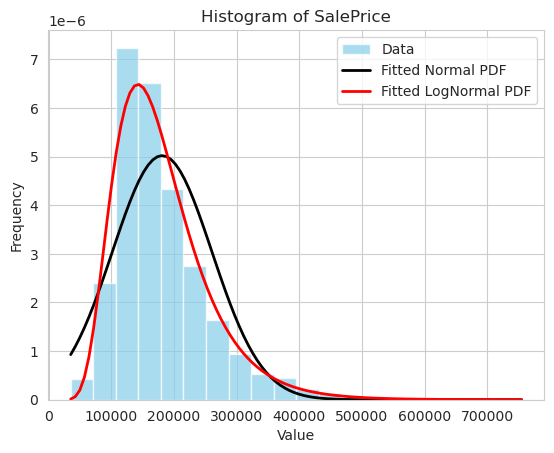

In [31]:
# Plot SalePrice normal and lognormal pdf
df_y = df_train['SalePrice']
plt.figure()
column_data = df_y
plt.hist(column_data, bins=20, density=True, alpha=0.7, color='skyblue', label='Data')
x = np.linspace(min(column_data), max(column_data), 100)
# Paameters for the normal distribution
mean, stdev = norm.fit(column_data)
pdf_norm = norm.pdf(x, mean, stdev)
plt.plot(x, pdf_norm, 'k', linewidth=2, label='Fitted Normal PDF')
# Parameters for the log-normal distribution
shape,loc,scale = lognorm.fit(column_data)
pdf_lognorm = lognorm.pdf(x, s=shape, scale=scale)
plt.plot(x, pdf_lognorm, 'r', linewidth=2, label='Fitted LogNormal PDF')
plt.legend()
plt.title(f'Histogram of SalePrice')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

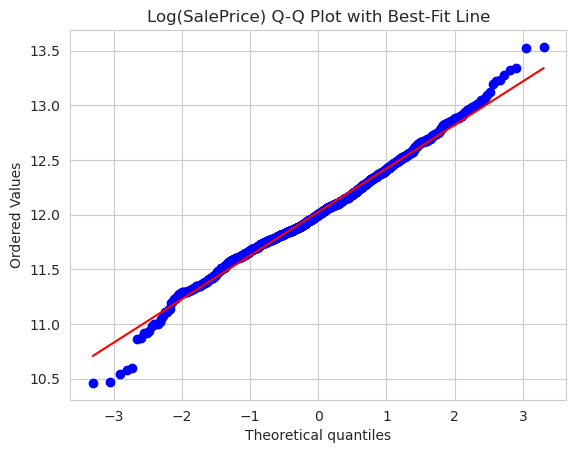

In [32]:
# QQ plot of SalePrice
fig, ax = plt.subplots();
stats.probplot(np.log(df_train['SalePrice']), dist="norm", plot=ax);
ax.set_title("Log(SalePrice) Q-Q Plot with Best-Fit Line");

## Define the response variable of train as y_train = log(SalePrice)

In [33]:
y_train = np.log(df_train['SalePrice'])
print('y_train shape: ',y_train.shape)

y_train shape:  (1458,)


## Split the combined data back into train and test data sets

In [34]:
#Split the data back into the training and test sets
X_train = data8[:df_train.shape[0]]
X_test = data8[df_train.shape[0]:]

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)

X_train shape:  (1458, 319)
X_test shape:  (1459, 319)


## Stacking regression

Next we will use the **stacking** function from the stepAIC module (https://github.com/gjpelletier/stepAIC). 

The **stacking** function in the stepAIC module provides output of a fitted regression model and summary statistics using the sklearn StackingRegressor function for ensemble modeling with any combination of sklearn base regressors which can be turned 'on' or 'off' with the following optional keyword arguments:

- Lasso= 'on' (default) or 'off'        uses LassoCV
- Ridge= 'on' (default) or 'off'        uses RidgeCV
- ElasticNet= 'on' (default) or 'off'   uses ElasticNetCV
- SGD= 'on' (default) or 'off'          uses SGDRegressor
- KNN= 'on' (default) or 'off'          uses KNeighborsRegressor
- SVR= 'on' (default) or 'off'          uses SVR(kernel='rbf')
- MLP= 'on' or 'off' (default)          uses MLPRegressor
- XGB= 'on' (default) or 'off'          uses GradientBoostingRegressor
- DecisionTree= 'on' (default) or 'off' uses DecisionTreeRegressor
- RandomForest= 'on' (default) or 'off' uses RandomForestRegressor

Stacking regression is an **ensemble** machine learning technique that improves predictive accuracy by combining multiple base regression models. Instead of selecting a single best model, stacking leverages multiple models to generate a more robust final prediction.

Fitting StackingRegressor models, please wait ...


StackingRegressor statistics of fitted ensemble model in model_outputs['stats']:


| Statistic          |   StackingRegressor |
|:-------------------|--------------------:|
| r-squared          |         0.945493    |
| adjusted r-squared |         0.930214    |
| n_samples          |      1458           |
| df residuals       |      1139           |
| df model           |       318           |
| F-statistic        |        62.1307      |
| Prob (F-statistic) |         1.11022e-16 |
| RMSE               |         0.0932881   |
| Log-Likelihood     |      1389.66        |
| AIC                |     -2141.31        |
| BIC                |      -455.453       |


Strength coefficients of base_regressors in model_outputs['strength']:


- positive intercept suggests base models under-predict target
- negative intercept suggests base models over-predict target
- positive coefficients have high importance
- coefficients near zero have low i

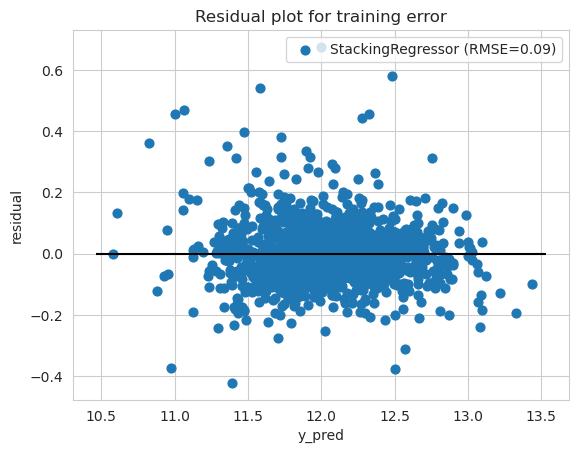

In [35]:
from stepAIC import stacking
model_object, model_output = stacking(X_train, y_train)

## Display summary statistics of regression results 

The following cell displays the saved regression statistics for the results of the final fitted model.

In [43]:
print(model_output['stats'])

                    StackingRegressor
Statistic                            
r-squared                9.454935e-01
adjusted r-squared       9.302144e-01
n_samples                1.458000e+03
df residuals             1.139000e+03
df model                 3.180000e+02
F-statistic              6.213074e+01
Prob (F-statistic)       1.110223e-16
RMSE                     9.328809e-02
Log-Likelihood           1.389655e+03
AIC                     -2.141310e+03
BIC                     -4.554525e+02


## Save the results as the submission.csv

Note that the RMSE of the training data does not necessarily indicate the best score with the test data, although in this case it does. I submitted the resuts using LassoCV, LassoLarsCV, LassoLarsAIC, and LassoLarsBIC. The test predictions using LassoCV resulted in my best submission on the kaggle leaderboard with a score of 0.12561 and rank of 753

In [38]:
# Make predictions
y_pred = model_object.predict(X_test)
SalePrice = np.exp(y_pred)

result = pd.DataFrame([df_test['Id'],SalePrice]).T
result.rename(columns={'Unnamed 0': 'SalePrice'}, inplace=True)
result['Id'] = result['Id'].astype(int)
result.to_csv('submission_StackingRegressor_v14.csv', index=False)

print("Predicted SalePrice for test data set: \n", result)

Predicted SalePrice for test data set: 
         Id      SalePrice
0     1461  120632.939163
1     1462  151979.949794
2     1463  179682.403459
3     1464  193964.405870
4     1465  198844.407923
...    ...            ...
1454  2915   86419.902467
1455  2916   81641.963252
1456  2917  160413.743092
1457  2918  121120.793252
1458  2919  224248.784092

[1459 rows x 2 columns]


## Check the QQ plot of log(SalePrice) comparing training data with predicted test data

The log-normal distributions of observed SalePrice in the train data set and predicted SalePrice in the test dataset look very similar 

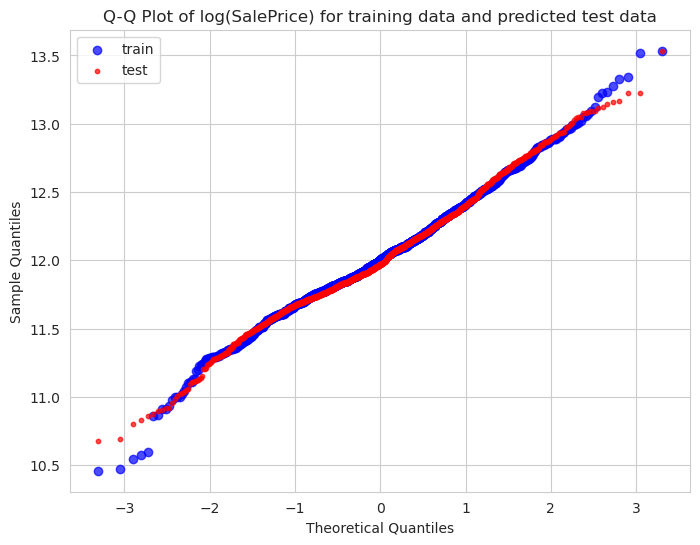

In [40]:
# QQ plot of training data and predicted SalePrice

# assign data1=train and data2=test
# data1 = np.log(df_train_num['SalePrice'])
# data2 = np.log(result['SalePrice'])
data1 = y_train
data2 = np.log(result['SalePrice'])

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first dataset
plt.scatter(qq1[0][0], qq1[0][1], color='blue', label='train', alpha=0.7)

# Plot the second dataset
plt.scatter(qq2[0][0], qq2[0][1], color='red', label='test', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of log(SalePrice) for training data and predicted test data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()

# Show the plot
plt.show()


## User help for the stacking function of stepAIC

In [42]:
help(stacking)

Help on function stacking in module stepAIC:

stacking(X, y, **kwargs)
    Python function for StackingRegressor linear regression

    by
    Greg Pelletier
    gjpelletier@gmail.com
    30-May-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        standardize= 'on' (default) or 'off' where
            'on': standardize X using sklearn.preprocessing StandardScaler
            'off': do not standardize X (only used if X is already standardized)
        random_state= (default random_state=42)        - initial random seed

        The following keyword arguments activate/deactivate selected base_regressors,
        and any combination of the following base_regressors may be 'on' or 'off':

       